<a href="https://colab.research.google.com/github/kivvgsr/deep-learning/blob/main/team1_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
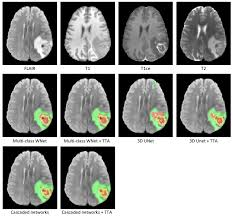
#### Brain tumor segmentation is a critical task in medical imaging that helps in diagnosing and treating brain tumors effectively. The goal of this project is to develop an automated deep learning-based model for brain tumor segmentation using Convolutional Neural Networks (CNNs). This model utilizes a U-Net architecture to accurately segment tumor regions from MRI scans. The dataset consists of MRI images and corresponding masks that indicate tumor locations. The project follows a structured approach, including data preprocessing, model training, evaluation, and visualization.






# **Data Loading**


*   The dataset consists of brain MRI images and their corresponding segmentation masks.

*   Paths to image and mask directories are defined to facilitate easy data access.
*   A function is implemented to load and preprocess images, including:
    
       *   Resizing to a fixed shape (128x128).

       *   Contrast enhancement using CLAHE (Contrast Limited Adaptive Histogram Equalization).
       *   Normalization of pixel values to [0,1] range for better model performance.
       *   Expanding the mask dimensions to match model input requirements.









In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
IMAGE_PATH = "/content/drive/MyDrive/archive (1)/images"
MASK_PATH = "/content/drive/MyDrive/archive (1)/masks"

# Check if paths are correct
print("Images:", os.listdir(IMAGE_PATH)[:5])  # List the first 5 image files
print("Masks:", os.listdir(MASK_PATH)[:5])    # List the first 5 mask files


Mounted at /content/drive
Images: ['2854.png', '2843.png', '2840.png', '2844.png', '2877.png']
Masks: ['2860.png', '2857.png', '2861.png', '286.png', '2865.png']


#**Importing the required packages**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from glob import glob
from albumentations import Compose, HorizontalFlip, VerticalFlip, RandomRotate90, GridDistortion, ElasticTransform

#**Visualizing Images and Masks**
* A function is used to display sample images alongside their corresponding tumor masks.
* Tumor areas are highlighted in the original image using red contours to provide better visibility.
* This visualization ensures the dataset is correctly loaded before training the model.

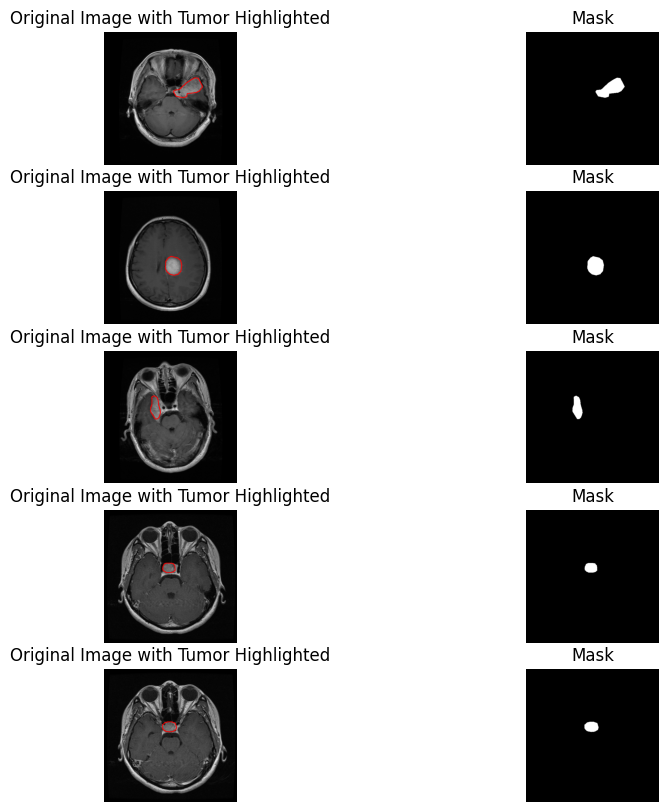

In [ ]:
def visualize_images_and_masks(image_path, mask_path, num_samples=5):
    image_files = sorted(glob(os.path.join(image_path, "*")))
    mask_files = sorted(glob(os.path.join(mask_path, "*")))

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10))
    for i in range(num_samples):
        img = cv2.imread(image_files[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_files[i], cv2.IMREAD_GRAYSCALE)

        # Find contours of the tumor region
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw red contours on the original image
        img_with_contours = img.copy()
        cv2.drawContours(img_with_contours, contours, -1, (255, 0, 0), 2)  # Red color circle

        axes[i, 0].imshow(img_with_contours)
        axes[i, 0].set_title("Original Image with Tumor Highlighted")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title("Mask")
        axes[i, 1].axis("off")

    plt.show()

visualize_images_and_masks(IMAGE_PATH, MASK_PATH)


# **Data Augmentation and Preprocessing**
* Augmentation is applied to increase dataset variability and improve generalization.
* Techniques used:
   * Horizontal and vertical flips
   * Random rotations
   * Grid distortion and elastic transformations
   
This helps the model generalize better to unseen data and reduces overfitting.

In [ ]:
# Advanced preprocessing with data augmentation
def advanced_preprocessing(img, mask, image_size=(128, 128)):
    img = cv2.resize(img, image_size)
    mask = cv2.resize(mask, image_size)

    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img[:, :, 0] = clahe.apply(img[:, :, 0])
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)

    # Normalize images and masks
    img = img / 255.0
    mask = mask / 255.0

    # Expand mask dimensions
    mask = np.expand_dims(mask, axis=-1)

    return img, mask


#**loading the dataset**

In [ ]:
# Load dataset
def load_images_and_masks(image_path, mask_path, image_size=(128, 128)):
    image_files = sorted(glob(os.path.join(image_path, "*")))
    mask_files = sorted(glob(os.path.join(mask_path, "*")))

    images, masks = [], []
    for img_file, mask_file in zip(image_files, mask_files):
        img = cv2.imread(img_file)
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        img, mask = advanced_preprocessing(img, mask, image_size)
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# **Train test split**

In [ ]:
# Load data
images, masks = load_images_and_masks(IMAGE_PATH, MASK_PATH)
train_x, valid_x, train_y, valid_y = train_test_split(images, masks, test_size=0.2, random_state=42)

# **Model Architecture: U-Net**
* U-Net is a widely used fully convolutional network for medical image segmentation.
* It consists of:
   1. Encoder (contracting path): Extracts image features using convolutional layers and max pooling.
   2. Bottleneck layer: Captures essential features before upsampling.
   3. Decoder (expanding path): Uses upsampling and concatenation to restore the original image size.
   4. Final output layer: A 1x1 convolution with a sigmoid activation function to predict tumor regions.


In [ ]:
# Build U-Net model
def unet_model(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # Encoding
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoding
    u4 = UpSampling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

#  **Model Training**
* The model is compiled using:
  * Binary cross-entropy loss for pixel-wise classification.
  * Adam optimizer for efficient learning.
  * Accuracy as a performance metric.
* Callbacks such as early stopping and learning rate reduction are used to optimize training.


In [ ]:
# Train model
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='min'),
    EarlyStopping(monitor='val_loss', patience=5, mode='min')
]

history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=25, batch_size=16, callbacks=callbacks)

# **Model Evaluation**
* The trained model is evaluated on a validation set using loss and accuracy metrics.
* The performance is analyzed to ensure the model is learning effectively.

In [ ]:
# Evaluate model
def evaluate_model():
    loss, accuracy = model.evaluate(valid_x, valid_y)
    print(f"Validation Loss: {loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")

evaluate_model()

# **Visualizing Predictions**
* The model's predictions are displayed alongside the original image and ground truth mask.
* Tumor regions in the original image are highlighted using red contours based on the model's predictions.
* This visualization helps assess the accuracy of segmentation and identify potential improvements.

In [ ]:
# Visualize predictions
def visualize_predictions(model, images, masks, num_samples=5):
    predictions = model.predict(images[:num_samples])
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 12))
    for i in range(num_samples):
        img = images[i].copy()
        mask = (predictions[i].squeeze() > 0.5).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        img = (img * 255).astype(np.uint8)
        cv2.drawContours(img, contours, -1, (255, 0, 0), 2)

        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image with Predicted Tumor")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(predictions[i].squeeze(), cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.show()

visualize_predictions(model, valid_x, valid_y)

#** Save the model**

In [ ]:
# Save the model in .h5 format after training
model.save("unet_model.h5", save_format="h5")

# **Conclusion**
This project successfully implements an automated brain tumor segmentation system using deep learning. The U-Net model provides accurate segmentation results, enabling early detection and aiding in clinical decision-making. Future improvements can include fine-tuning hyperparameters, using a larger dataset, and incorporating post-processing techniques for better segmentation accuracy.

In [ ]:
from google.colab import files

# Save the model in .h5 format
model.save("unet_model.h5")

# Download the model
files.download("unet_model.h5")


In [ ]:
model.summary()

In [ ]:
print("y_pred shape:", y_pred.shape, "dtype:", y_pred.dtype)
print("y_true shape:", valid_y.shape, "dtype:", valid_y.dtype)


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import jaccard_score, accuracy_score, confusion_matrix

# Function to calculate Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

# Get predictions
y_pred = model.predict(valid_x)

# Threshold the predictions (assuming binary segmentation)
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)
y_true_thresholded = (valid_y > 0.5).astype(np.uint8)  # Ensure ground truth is also binary

# Flatten for metric computation
y_true_flat = y_true_thresholded.flatten()
y_pred_flat = y_pred_thresholded.flatten()

# Compute IoU (Jaccard Index) - Ensure binary values
iou = jaccard_score(y_true_flat, y_pred_flat, average='binary')

# Compute Dice Coefficient
dice = dice_coefficient(y_true_flat, y_pred_flat)

# Compute Pixel Accuracy
pixel_accuracy = accuracy_score(y_true_flat, y_pred_flat)

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

print(f"IoU Score: {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
